In [1]:
import argparse
import json
from pprint import pprint
import torch
import torch.nn.functional as F

import numpy as np

# from model_wrapper import ModelNoOpWrapper, ModelWrapper
from datasets.shapenet_data_pc import ShapeNet15kPointClouds

# Settings
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"


def get_datasets(category, dataroot, npoints=2048):
    tr_dataset = ShapeNet15kPointClouds(
        root_dir=dataroot,
        categories=category,
        split="train",
        tr_sample_size=npoints,
        te_sample_size=npoints,
        scale=1.0,
        normalize_per_shape=False,
        normalize_std_per_axis=False,
        random_subsample=True,
    )
    te_dataset = ShapeNet15kPointClouds(
        root_dir=dataroot,
        categories=category,
        split="val",
        tr_sample_size=npoints,
        te_sample_size=npoints,
        scale=1.0,
        normalize_per_shape=False,
        normalize_std_per_axis=False,
        all_points_mean=tr_dataset.all_points_mean,
        all_points_std=tr_dataset.all_points_std,
        random_subsample=False,
    )
    return te_dataset

# dm = load_datamodule(encoder_config.data)
te_ds = get_datasets(
    ["airplane"],
    "../data/shapenet/raw/ShapeNetCore.v2.PC15k",
)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Total number of data:2832
Min number of points: (train)2048 (test)2048
Total number of data:405
Min number of points: (train)2048 (test)2048


In [2]:
from layers.directions import generate_uniform_directions
from layers.ect import compute_ect_point_cloud
from loaders import load_config


config, _ = load_config("./configs/encoder_airplane.yaml")


tr_pc = te_ds[0]["train_points"].view(1,2048,3).cuda()
v = generate_uniform_directions(
            num_thetas=config.ectconfig.num_thetas,
            d=config.ectconfig.ambient_dimension,
            seed=config.ectconfig.seed,
        ).cuda()
ect = (
            compute_ect_point_cloud(
                x=tr_pc,
                v=v,
                radius=config.ectconfig.r,
                resolution=config.ectconfig.resolution,
                scale=config.ectconfig.scale,
            )
            / 2048
        )

In [3]:
print(config.ectconfig.seed)
print(config.ectconfig.scale)

2024
64


In [4]:
tr_pc = te_ds[0]["train_points"].view(1,2048,3).cuda()
v = generate_uniform_directions(
            num_thetas=config.ectconfig.num_thetas,
            d=config.ectconfig.ambient_dimension,
            seed=config.ectconfig.seed,
        ).cuda()
ect = (
            compute_ect_point_cloud(
                x=tr_pc,
                v=v,
                radius=config.ectconfig.r,
                resolution=config.ectconfig.resolution,
                scale=config.ectconfig.scale,
            )
            / 2048
        )

tensor(0., device='cuda:0')
tensor(1., device='cuda:0')


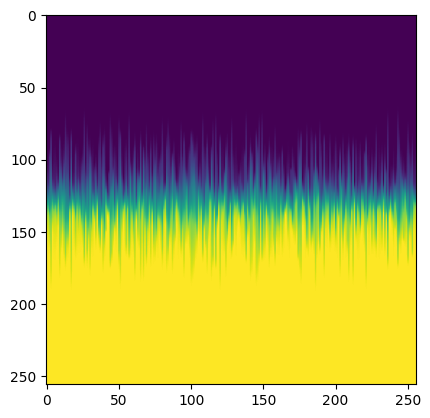

In [5]:
import matplotlib.pyplot as plt

print(ect.min())
print(ect.max())

plt.imshow(ect.squeeze().cpu().numpy())


In [6]:
from loaders import load_datamodule
print(config.data)
config.data.root = "../data/shapenet"
dm = load_datamodule(config.data)

namespace(module='datasets.shapenetcore', root='./data/shapenet', cates=['airplane'], num_workers=0, batch_size=64, pin_memory=True, drop_last=False, force_reload=False, ectconfig=namespace(seed=2024, num_thetas=256, resolution=256, scale=64, r=7, ect_type='points', ambient_dimension=3, normalized=True))


In [7]:
pc = dm.val_ds[0].ect
pts = dm.val_ds[0].x
# plt.imshow(pc.squeeze().cpu().numpy()-ect.squeeze().cpu().numpy())


tensor(1.7887e-05)


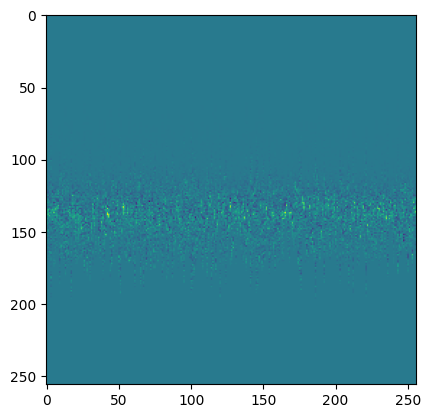

In [8]:
tr_pc = te_ds[0]["test_points"].view(1,2048,3).cuda()
# tr_pc = dm.val_ds[0].x.unsqueeze(0).cuda()
v = generate_uniform_directions(
            num_thetas=config.ectconfig.num_thetas,
            d=config.ectconfig.ambient_dimension,
            seed=2024,
        ).cuda()
ect_new = (
            compute_ect_point_cloud(
                x=tr_pc,
                v=v,
                radius=config.ectconfig.r,
                resolution=config.ectconfig.resolution,
                scale=64,
            )          
        )

ect_new = ect_new / ect_new.max()

print(torch.norm(pc.squeeze().cpu()-ect_new.squeeze().cpu()))
plt.imshow(pc.squeeze().cpu().numpy()-ect_new.squeeze().cpu().numpy());

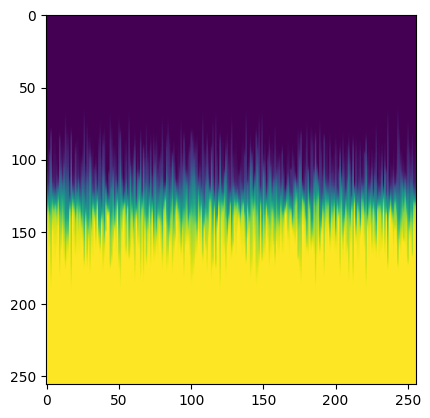

In [9]:
plt.imshow(pc.squeeze().cpu().numpy())

In [10]:
print(pc.min())
print(pc.max())



tensor(0.)
tensor(1.)


In [11]:
import pyvista as pv 
pv.set_jupyter_backend("server")
pl = pv.Plotter()

pl.add_points(tr_pc.squeeze().cpu().numpy(),render_points_as_spheres=True,color="red")
pl.add_points(pts.squeeze().cpu().numpy(),render_points_as_spheres=True)

pl.show()

Widget(value='<iframe src="http://localhost:46441/index.html?ui=P_0x7faa2b23bd00_0&reconnect=auto" class="pyvi…

In [16]:
from metrics.evaluation import EMD_CD


old_val = dm.val_ds.x.view(-1,2048,3).cuda()
new_val = torch.cat([data["test_points"].view(1,2048,3) for data in te_ds]).cuda()
print(old_val.shape)
print(new_val.shape)
res = EMD_CD(old_val,new_val,batch_size=10,reduced=False)

torch.Size([405, 2048, 3])
torch.Size([405, 2048, 3])


In [13]:
print(res["MMD-CD"].mean())
print(res["MMD-EMD"].mean())
d,idxs = torch.topk(res["MMD-CD"],k=10,largest=False)
print(d)

tensor(0., device='cuda:0')
tensor(9.3396e-07, device='cuda:0')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')


In [14]:
i = 0

import pyvista as pv 
pv.set_jupyter_backend("server")
pl = pv.Plotter()

pl.add_points(old_val[idxs[1]].squeeze().cpu().numpy(),render_points_as_spheres=True,color="red")
pl.add_points(new_val[idxs[1]].squeeze().cpu().numpy(),render_points_as_spheres=True)

pl.show()

Widget(value='<iframe src="http://localhost:46441/index.html?ui=P_0x7fa9b7723790_1&reconnect=auto" class="pyvi…